In [2]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import os
import glob
from dask.diagnostics import ProgressBar
from wmt_inert_tracer.preprocessing import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
rootdir = '/home/Jan-erik.Tesdal/data/raw/'
fafdir = '/home/Jan-erik.Tesdal/fafmip/data/raw/'
pp = 'ocean_monthly'
var = 'MLD_restrat'

ddict = {s:{} for s in ['CM4','ESM4']}
for mod in ddict:
    
    # Load the static grid data
    if mod == 'CM4':
        subdir = 'CM4_piControl_C'
        grid = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
    elif mod == 'ESM4':
        subdir = 'ESM4_piControl_D'
        grid = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
    else:
        print('grid is not available for'+mod)
        
    ddict_exp = {s:{} for s in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        
        if exp == 'control':
            full_path = os.path.join(rootdir,subdir,pp)
            print('Loading %s for '%var+mod+'-'+exp+' in',os.path.basename(subdir))
            #print('dmls -lah `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`')
            #print('dmget `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`','&','\n')
            ds = xr.open_mfdataset(full_path+'/'+pp+'.*.%s.nc'%var, use_cftime=True,
                                   drop_variables=['average_DT','average_T1','average_T2'])
            ddict_exp[exp] = preprocessing(ds,grid,verbose=False)
                
        else:
            files = glob.glob(os.path.join(fafdir,subdir+'_faf'+exp+'_*'))
            ddict_mem = {}
            for file in sorted(files):
                full_path = os.path.join(file,pp)
                print('Loading %s for '%var+mod+'-'+exp+'-'+file[-3:]+' in',os.path.basename(file))
                #print('dmls -lah `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`')
                #print('dmget `readlink -f ',full_path+'/'+pp+'.*.%s.nc'%var+'`','&','\n')
                ds = xr.open_mfdataset(full_path+'/'+pp+'.*.%s.nc'%var,use_cftime=True,
                                       drop_variables=['average_DT','average_T1','average_T2'])
                ddict_mem[file[-3:]] = preprocessing(ds,grid,verbose=False)
            
            ddict_exp[exp] = ddict_mem
            
    ddict[mod] = ddict_exp

Loading MLD_restrat for CM4-control in CM4_piControl_C
Loading MLD_restrat for CM4-antwater-251 in CM4_piControl_C_fafantwater_251
Loading MLD_restrat for CM4-antwater-290 in CM4_piControl_C_fafantwater_290
Loading MLD_restrat for CM4-antwater-332 in CM4_piControl_C_fafantwater_332
Loading MLD_restrat for CM4-antwater-369 in CM4_piControl_C_fafantwater_369
Loading MLD_restrat for CM4-antwater-424 in CM4_piControl_C_fafantwater_424
Loading MLD_restrat for CM4-stress-251 in CM4_piControl_C_fafstress_251
Loading MLD_restrat for CM4-stress-290 in CM4_piControl_C_fafstress_290
Loading MLD_restrat for CM4-stress-332 in CM4_piControl_C_fafstress_332
Loading MLD_restrat for CM4-stress-369 in CM4_piControl_C_fafstress_369
Loading MLD_restrat for CM4-stress-424 in CM4_piControl_C_fafstress_424
Loading MLD_restrat for CM4-antwaterstress-251 in CM4_piControl_C_fafantwaterstress_251
Loading MLD_restrat for CM4-antwaterstress-290 in CM4_piControl_C_fafantwaterstress_290
Loading MLD_restrat for CM4-a

In [5]:
reg =  None # Weddell, Ross
north = -55

if reg=='Weddell':
    west,east = -65,0
elif reg=='Ross':
    west,east = 150-360,-120
else:
    west,east = None,None

### Calculate time series of maximum MLD

In [6]:
from datetime import timedelta

In [6]:
tsdict = {mod:{} for mod in list(ddict.keys())}
for mod in tsdict:
    tsdict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
for mod in tsdict:
    for exp in tsdict[mod]:
        print(mod+'-'+exp)
        if exp=='control':
            ds = ddict[mod][exp].sel(x=slice(west,east),y=slice(None,north)).groupby('time.year').max('time')
            tsdict[mod][exp] = ds.where(ds.deptho>1000).sel(y=slice(None,-60)).max(dim=['x','y']).MLD_restrat
        else:
            das = []
            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                ds = ddict[mod][exp][str(mem)].sel(x=slice(west,east),y=slice(None,north))
                if mem == '101':
                    ds['time'] = ds.time - timedelta(days=365*(int(mem)-1))
                    
                ds = ds.groupby('time.year').max('time')
                da = ds.where(ds.deptho>1000).sel(y=slice(None,-60)).max(dim=['x','y']).MLD_restrat
                da['mem'] = int(mem)
                das.append(da)
                
            tsdict[mod][exp] = xr.concat(das, dim='mem')

CM4-control
CM4-antwater
CM4-stress
CM4-antwaterstress
ESM4-control
ESM4-antwater
ESM4-stress
ESM4-antwaterstress


### Save to file

In [9]:
outdir='/work/jet/data/fafmip/'
for mod in tsdict:
    for exp in tsdict[mod]:
        da = tsdict[mod][exp].reset_coords(drop=True)
        fname = '%s_%s_so_mld_max.nc'%(mod,exp)
        print('Saving to file:', fname)
        with ProgressBar():
            da.to_dataset(name='mld').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_control_so_mld_max.nc
[########################################] | 100% Completed |  7min  8.9s
Saving to file: CM4_antwater_so_mld_max.nc
[########################################] | 100% Completed |  1min 29.3s
Saving to file: CM4_stress_so_mld_max.nc
[########################################] | 100% Completed |  1min 14.9s
Saving to file: CM4_antwaterstress_so_mld_max.nc
[########################################] | 100% Completed |  1min 20.0s
Saving to file: ESM4_control_so_mld_max.nc
[########################################] | 100% Completed |  2min 36.0s
Saving to file: ESM4_antwater_so_mld_max.nc
[########################################] | 100% Completed | 23.7s
Saving to file: ESM4_stress_so_mld_max.nc
[########################################] | 100% Completed | 24.1s
Saving to file: ESM4_antwaterstress_so_mld_max.nc
[########################################] | 100% Completed | 25.9s


### Map of maximum MLD

In [7]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import cartopy_map_so
from compute import horizontal_mean
from matplotlib.backends.backend_pdf import PdfPages

In [39]:
mod = 'ESM4' # CM4, ESM4
exp = 'stress' # control, antwater, stress, antwaterstress
mem = 201 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)

yr = 40

In [40]:
if exp == 'control':
    ds = ddict[mod][exp].sel(x=slice(west,east),y=slice(None,north)).groupby('time.year').max('time')
else:
    ds = ddict[mod][exp][str(mem)].sel(x=slice(west,east),y=slice(None,north)).groupby('time.year').max('time')

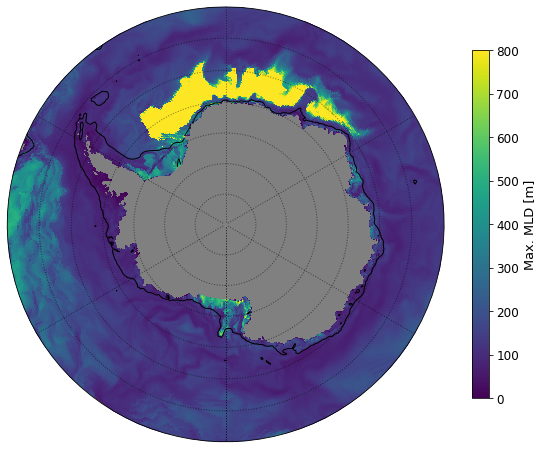

In [41]:
fig, ax = cartopy_map_so(ds.sel(year=yr), 'MLD_restrat', lat=north, fsize=[10,8],
                         drawGrid=True, blevels=[1000.0],vrange=[0,800], cb_label = 'Max. MLD [m]')

In [42]:
with PdfPages('/work/jet/figure.pdf') as pdf:
    for i in range(0,len(ds.year)):
        yrstr = str(ds.isel(year=i).year.values).rjust(4, '0')
        print(yrstr)
        fig, ax = cartopy_map_so(ds.isel(year=i), 'MLD_restrat', lat=north, fsize=[10,8], 
                                 drawGrid=True, blevels=[1000.0],vrange=[0,800],
                                 cb_label = 'Max. MLD [m]',title = 'Year '+yrstr)
        ax.set_rasterized(True)
        pdf.savefig()
        plt.close()

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036
0037
0038
0039
0040
0041
0042
0043
0044
0045
0046
0047
0048
0049
0050
0051
0052
0053
0054
0055
0056
0057
0058
0059
0060
0061
0062
0063
0064
0065
0066
0067
0068
0069
0070
0071
0072
0073
0074
0075
0076
0077
0078
0079
0080
0081
0082
0083
0084
0085
0086
0087
0088
0089
0090
0091
0092
0093
0094
0095
0096
0097
0098
0099
0100


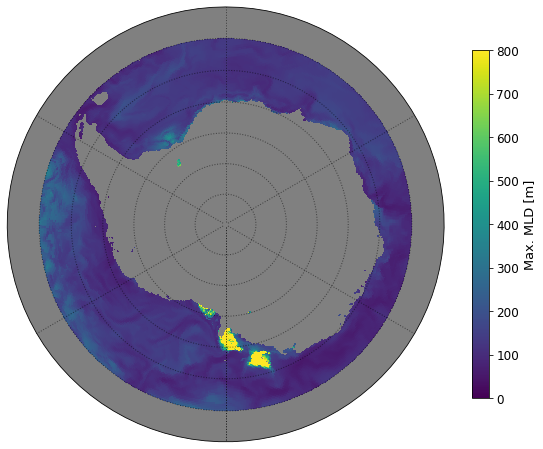

In [64]:
fig, ax = cartopy_map_so(ds.where(ds.deptho>1000).sel(y=slice(None,-60)).isel(year=-1), 'MLD_restrat', 
                         lat=north, fsize=[10,8],drawGrid=True, blevels=[1000.0],vrange=[0,800], 
                         cb_label = 'Max. MLD [m]')

### Time series of maximum MLD

In [69]:
with ProgressBar():
    mld_max = ds.where(ds.deptho>1000).sel(y=slice(None,-60)).max(dim=['x','y']).MLD_restrat.load()

[########################################] | 100% Completed |  3.8s


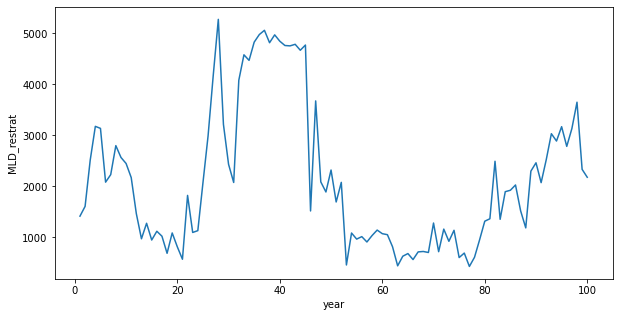

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
mld_max.plot(ax=ax)
plt.show()